In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
%matplotlib inline
import pickle
import os
import math

The path below depends on the which directory the Enron Spam data set is on your computer.

In [2]:
path = '/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/'

Preprocessing the data:<br>
**Warning:** Takes a long time to run(30 min on my laptop)<br>
spam_lst is a list where each element contains the entire text data of a spam document, similarly for ham_lst

In [3]:
ham_lst = []
spam_lst = []
# following code iterates through Enron1 ,.., Enron6 extracting the spam and ham emails
for d,sd,f in os.walk(path):
    print(d)
    if os.path.split(d)[1] == "ham":
        for filename in f:
            with open(os.path.join(d,filename),encoding="latin-1") as s:
                # input the data
                data = s.read()
                # tokenize the data
                data = word_tokenize(data)
                # convert to lower case words
                data = [word.lower() for word in data]
                # remove the stop words
                data = [word for word in data if word not in stopwords.words("english")]
                # use porter stemmer and lemmatization
                stemmer = PorterStemmer()
                lemmatizer = WordNetLemmatizer()
                data = [stemmer.stem(word) for word in data]
                data = [lemmatizer.lemmatize(word) for word in data]
                ham_lst.append(data)
    elif os.path.split(d)[1] == "spam":
        for filename in f:
            with open(os.path.join(d,filename),encoding="latin-1") as s:
                # input the data
                data = s.read()
                # tokenize the data
                data = word_tokenize(data)
                # convert to lower case words
                data = [word.lower() for word in data]
                # remove the stop words
                data = [word for word in data if word not in stopwords.words("english")]
                # use porter stemmer and lemmatization
                stemmer = PorterStemmer()
                lemmatizer = WordNetLemmatizer()
                data = [stemmer.stem(word) for word in data]
                data = [lemmatizer.lemmatize(word) for word in data]
                spam_lst.append(data)

/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron1
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron1/spam
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron1/ham
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron6
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron6/spam
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron6/ham
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron5
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron5/spam
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron5/ham
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron2
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron2/spam
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron2/ham
/Users/j.pruthvichowdary/Desktop/PRML_assignment3/Enron_Spam/enron3
/Users/j.pruthvich

In [4]:
# contain all the data into one list
ham_lst.extend(spam_lst)

Encode the data as<br>
0 --> ham<br>
1 --> spam<br>
Also run the tf-idf vectorizer to get the numerical features from data.

In [5]:
y = np.array([0]*(len(ham_lst)-len(spam_lst))+[1]*len(spam_lst))
# split into training and test data
txt_train,txt_test,y_train,y_test = train_test_split(ham_lst,y)
# combine words into sentences for running the tf-idf vectorizer
txt_train = [' '.join(words) for words in txt_train]
txt_test = [' '.join(words) for words in txt_test]

In [6]:
# define max features to limit the size of the matrix
vectorier = TfidfVectorizer(max_features=1000)
# fit and transform for train
X_train = vectorier.fit_transform(txt_train)
# only transform don't fit for test
X_test = vectorier.transform(txt_test)
# convert sparse matrix into ordinary matrix
X_train = X_train.toarray()
X_test = X_test.toarray()

Save the vectoriser above to be used during prediction.<br>
**Warning:** Do not delete the following file, deleting it might lead to errors during execution of the test script.

In [7]:
pickle.dump(vectorier,open("vectoriser",'wb'))

Gaussian Naive Bayes Classifier:

In [8]:
# training the classifier
# just get the means and standard deviations
k = len(np.unique(y_train))
mean = np.zeros((k,X_train.shape[1]))
std = np.zeros((k,X_train.shape[1]))
for i in range(k):
    mean[i] = np.mean(X_train[y_train == i],0)
    std[i] = np.std(X_train[y_train == i],0)
class_prob = []
for i in range(k):
    class_prob.append(np.sum(y_train == i) / len(y_train))

In [9]:
# add a small value for numerical stability
std += 1e-6
# store the predicted values
y_pred = []
for x in X_test:
    # here instead of product we are taking sum of log for numerical stability
    y_pred.append(np.argmax([-np.sum(np.log(std[i]) + (x-mean[i])**2/(2*std[i]**2)) + np.log(class_prob[i]) for i in range(k)]))

The accuracy is given by:

In [10]:
np.sum(y_pred == y_test) / len(y_test)

0.9678490924190295

Therefore we got an accuracy of about 97% on the Naive Bayes Classifier.

**Saving variables for use in prediction, do not delete them:**

In [11]:
pickle.dump(mean,open("mean",'wb'))
pickle.dump(std,open("std",'wb'))
pickle.dump(class_prob,open("class_prob",'wb'))

Logistic Regression Classifier:

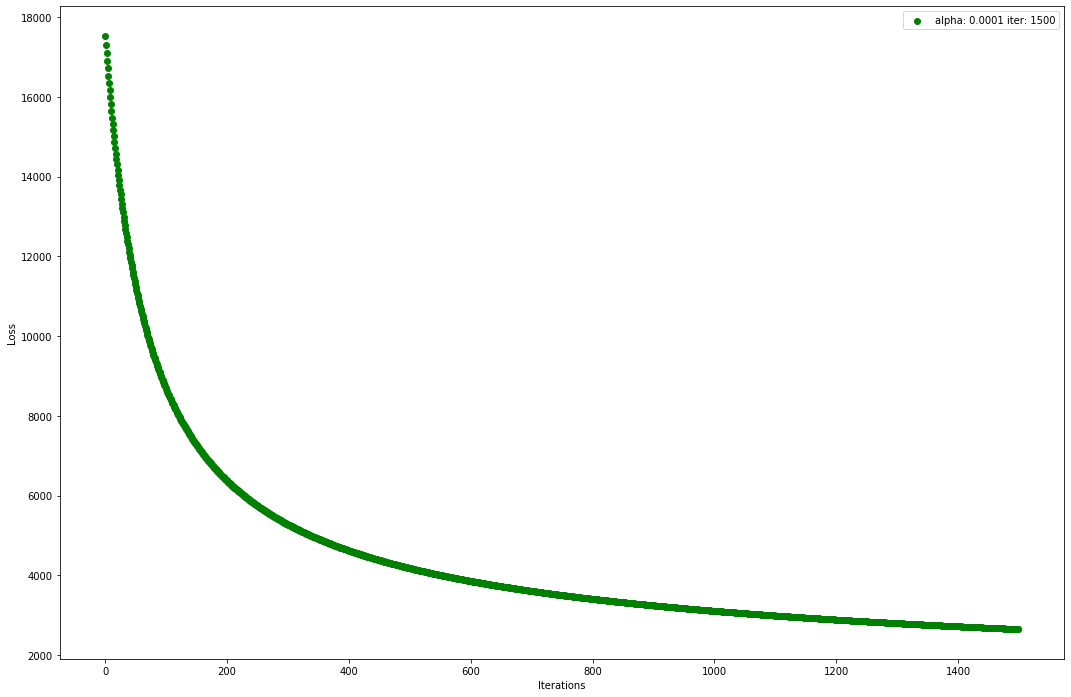

In [12]:
# we will now implement the above in code
# add a row of 1's to include a constant in linear function
X_train_affine = np.hstack([X_train,np.array([1]*len(X_train)).reshape(-1,1)])
X_test_affine = np.hstack([X_test,np.array([1]*len(X_test)).reshape(-1,1)])
y_train = y_train.reshape(-1,1)
min_loss = math.inf
alpha = 1e-4
itera = 1500
beta = np.random.randn(X_train_affine.shape[1],1) * 0.001
loss = []
for i in range(itera):
    # add the current loss to vector which is negative log liklihood
    loss.append( -(np.sum((X_train_affine @ beta) * y_train) - np.sum(np.log(1+np.exp(X_train_affine @ beta)))) )
    # calulate the gradient
    grad = (np.sum(y_train * X_train_affine,0) - np.sum(X_train_affine / (1 + np.exp(-X_train_affine @ beta)),0)).reshape(-1,1)
    # update using gradient ascent update rule, to maximize log liklihood
    beta = beta + alpha * grad
plt.figure(figsize=(18,12))
plt.scatter(list(range(len(loss))),loss,c='g',label="alpha: "+str(alpha)+" iter: "+str(itera))
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [13]:
y_train = y_train.ravel()
y_pred = ((X_test_affine @ beta) > 0)
np.sum(y_pred.ravel() == y_test) / len(y_test)

0.97532328864634

So we got an accuracy of 97.4% using Logistic regression classifier.

**Saving variables for use in prediction, do not delete them:**

In [14]:
pickle.dump(beta,open("beta",'wb'))

Support Vector Machines

In [15]:
clf = SVC(kernel="rbf")

In [16]:
clf.fit(X_train,y_train.ravel())

/Users/j.pruthvichowdary/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
y_pred = clf.predict(X_test)
np.sum(y_pred.ravel() == y_test) / len(y_test)

0.8780400996559496

Rbf kernel is not giving good accuracy so we will stick with linear.

In [18]:
# since we have already split the data, we can use X_test as a validation code:
val_acc = []
for C in np.logspace(0,2,10):
    # fit the data
    clf = SVC(kernel="linear",C=C)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    val_acc.append(np.sum(y_pred.ravel() == y_test) / len(y_test))

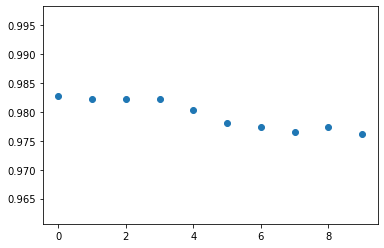

In [19]:
plt.scatter(list(range(len(val_acc))),val_acc)

In [20]:
max(val_acc)

0.9827974848736505

We can see that SVM gives an accuracy of 97.9%<br>
best value of C is

In [21]:
C = np.logspace(0,2,10)[np.argmax(val_acc)]
C

1.0

In [22]:
# retrain the classifier
clf = SVC(kernel="linear",C=C)
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

**Saving variables for use in prediction, do not delete them:**

In [23]:
pickle.dump(clf,open("svm_clf",'wb'))